In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from collections import Counter
from scipy.stats import binom
from scipy import stats

In [2]:
def read_regionfile(directory, file_name):
    with open(directory + file_name) as f:
        gems = {}
        for line in f:
            tmp = line.strip().split("\t")
            gemid = tmp[4]
            if gemid in gems.keys():
                gems[gemid].append(tmp[5:])
            else:
                gems[gemid] = [tmp[5:]]
    return gems

In [3]:
def read_elementsfile(directory, file_name):
    with open(directory + file_name) as f:
        elements = {}
        for line in f:
            tmp = line.strip().split("\t")
            raidid = tmp[4]
            tmp[1] = int(tmp[1])
            tmp[2] = int(tmp[2])
            if raidid in elements.keys():
                elements[raidid].append(tmp)
            else:
                elements[raidid] = [tmp]
    return elements

In [4]:
def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

In [5]:
def plotscatter(x1,x2,  tit, xlab, ylab, fig_name):
    samples = np.array([x1, x2])
    densObj = kde( samples )
    colours = makeColours( densObj.evaluate( samples ) )
    plt.figure(figsize=(7,7))
    plt.scatter( samples[0], samples[1], color=colours , alpha = 0.5, edgecolors='none')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    pearson = round(scipy.stats.pearsonr(x1, x2)[0], 2)
    spearman = round(scipy.stats.spearmanr(x1, x2)[0], 2)
    plt.title(tit+ "\n Pearson = " + str(pearson)+", Spearman = " + str(spearman) + ", n="+str(len(x1)), fontsize=15)
    #plt.savefig(fig_name + ".pdf", dpi=300)
    plt.show()

In [6]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    plt.title(tit, fontsize = 18)
    #plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [7]:
def compute_exp(fragdict, prob):
    exp = [0,0,0,0,0]
    for n, samp in fragdict.items():
        pmf = [0,0,0,0,0]
        pmf[0] = binom.pmf(0, int(n), p=prob)
        pmf[1] = binom.pmf(1, int(n), p=prob)
        pmf[2] = binom.pmf(2, int(n), p=prob)
        if int(n)>2:
            pmf[3] = binom.pmf(3, int(n), p=prob)
        if int(n)>3:
            pmf[4] = 1-pmf[0]-pmf[1]-pmf[2]-pmf[3]
        dist = [x*samp for x in pmf]
        exp = [a+b for a, b in zip(exp, dist)]
    expcnt = [int(round(x)) for x in exp]
    expcnt[4] = sum(fragdict.values())-sum(expcnt[0:4])
    return expcnt

In [8]:
def plot_barchart(x, y, ylab, clr, tit, fig_name):
    fig = plt.figure(figsize = (6,6))
    plt.bar(x, y, width = 0.7, color = clr)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    plt.title(tit, fontsize = 18)
    #plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [54]:
directory='/Users/kimm/Desktop/GM12878_files/'
#cohesin_rfile='GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth.region.PEanno'
#rnapii_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS.RNAPII-peaksoverlap.region'
#ctcf_rfile='GM12878-CTCF-pooled_comp_FDR_0.2_PASS_motifext4kbboth.region.PEanno'
cohesin_rfile='GM12878-cohesin-pooled_comp_FDR_0.1_ALL_motifext4kbboth.region.PEanno'
rnapii_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_ALL.RNAPII-peaksoverlap.region'
ctcf_rfile='GM12878-CTCF-pooled_comp_FDR_0.1_ALL_motifext4kbboth.region.PEanno'
elements_file='RNAPII-ChIA-PET-drop_peaks_merge500bp-superenhancer_const_chromHMM_ENCFF879KFK_RAID_20200729.bed'

In [55]:
rnapiir = read_regionfile(directory, rnapii_rfile)

In [56]:
len(rnapiir)

6060081

In [57]:
rnapii_fragd = {}
for key, val in rnapiir.items():
    fragn = str(len(val))
    if fragn not in rnapii_fragd.keys():
        rnapii_fragd[fragn] = 1
    else:
        rnapii_fragd[fragn] += 1

In [58]:
binom.pmf(1, n = 2, p=0.0544)

0.10288128000000005

In [15]:
ctcfr = read_regionfile(directory, ctcf_rfile)

In [16]:
ctcf_fragd = {}
#motcnt = dict.fromkeys(['0M', '1M', '2M', '3M', 'GE4M'], 0)
motcnt = [0, 0, 0, 0, 0]
for key, val in ctcfr.items():
    fragn = str(len(val))
    motn = len([x[0] for x in val if x[0]=='P'])
    if motn == 0:
        motcnt[0] += 1
    elif motn == 1:
        motcnt[1] += 1
    elif motn == 2:
        motcnt[2] += 1
    elif motn == 3:
        motcnt[3] += 1
    elif motn > 3:
        motcnt[4] += 1
    #print(sorted([x[0] for x in val]))
    if fragn not in ctcf_fragd.keys():
        ctcf_fragd[fragn] = 1
    else:
        ctcf_fragd[fragn] += 1

In [17]:
cohesinr = read_regionfile(directory, cohesin_rfile)

In [18]:
cohesin_fragd = {}
#motcnt = dict.fromkeys(['0M', '1M', '2M', '3M', 'GE4M'], 0)
motcnt_coh = [0, 0, 0, 0, 0]
for key, val in cohesinr.items():
    fragn = str(len(val))
    motn = len([x[0] for x in val if x[0]=='P'])
    if motn == 0:
        motcnt_coh[0] += 1
    elif motn == 1:
        motcnt_coh[1] += 1
    elif motn == 2:
        motcnt_coh[2] += 1
    elif motn == 3:
        motcnt_coh[3] += 1
    elif motn > 3:
        motcnt_coh[4] += 1
    #print(sorted([x[0] for x in val]))
    if fragn not in cohesin_fragd.keys():
        cohesin_fragd[fragn] = 1
    else:
        cohesin_fragd[fragn] += 1

In [19]:
motcnt_coh

[11297782, 6476693, 1371284, 61531, 9289]

In [20]:
motif_exp_coh = compute_exp(cohesin_fragd, 168114665/3088286401)

In [21]:
motif_exp_coh

[16982191, 2142449, 87684, 3269, 986]

In [22]:
motcnt

[3668253, 1558737, 307038, 9623, 1323]

In [23]:
motif_exp = compute_exp(ctcf_fragd, 168114665/3088286401)

In [24]:
motif_exp

[4892383, 625485, 26192, 796, 118]

In [25]:
print([x*100/sum(motif_exp) for x in motif_exp])

[88.23094571768956, 11.280215200287683, 0.47235568642882725, 0.014355342333435649, 0.002128053260484179]


In [59]:
prom_exp = compute_exp(rnapii_fragd, 49004649/3088286401)

In [60]:
prom_exp

[5844667, 212692, 2689, 32, 1]

In [61]:
print([x*100/sum(prom_exp) for x in prom_exp])

[96.44536104385404, 3.5097220647710814, 0.0443723441980396, 0.0005280457472433125, 1.6501429601353515e-05]


In [62]:
ep_stat = []
#genes_3P = []
for key, val in rnapiir.items():
    tmp_pe = []
    #pgenes = []
    for x in val:
        annot = x[5][0:3]
        geneid = x[12]
        if annot in ['RAP', 'RWP', 'RPE', 'REN', 'ROT'] and geneid != '.': # promoter
            tmp_pe.append('AP') # active promoter
            #pgenes.append([x[5], x[10], x[12], float(x[13])])
        if annot in ['RAP', 'RWP', 'RPE'] and geneid == '.':
            tmp_pe.append('PP') # poised promoter
            #pgenes.append([x[5], x[10], x[12], 0])
        if annot in ['REN'] and geneid == '.': # enhancer
            tmp_pe.append('EN')
    ap_n = len([x for x in tmp_pe if x=='AP'])
    pp_n = len([x for x in tmp_pe if x=='PP'])
    en_n = len([x for x in tmp_pe if x=='EN'])
    #ot_n = str(len([x for x in tmp if x=='OT']))
    #ep_stat.append(ap_n+'AP,'+pp_n+'PP,'+en_n+'EN,'+ot_n+'OT')
    ep_stat.append(str(ap_n)+'AP,'+str(pp_n)+'PP,'+str(en_n)+'EN')
    #if len(pgenes)==3:
        #genes_3P.append(pgenes)
    #tmpdict = Counter(tmp)
    #print(tmpdict)

In [64]:
len(ep_stat)

6060081

In [65]:
ep_stat_cnt = Counter(ep_stat)

In [66]:
#promcnt = dict.fromkeys(['0P', '1P', '2P', '3P', 'GE4P'], 0)
#enhcnt = dict.fromkeys(['0E', '1E', '2E', '3E', 'GE4E'], 0)
promcnt = [0,0,0,0,0]
enhcnt = [0,0,0,0,0]
enh_fragd = {}
for key, val in ep_stat_cnt.items():
    triplet = key.split(",")
    ap_n = int(triplet[0].split("AP")[0])
    pp_n = int(triplet[1].split("PP")[0])
    en_n = int(triplet[2].split("EN")[0])
    if ap_n + pp_n == 0:
        promcnt[0] += val
        if en_n == 0:
            enhcnt[0] += val
        elif en_n == 1:
            enhcnt[1] += val
        elif en_n == 2:
            enhcnt[2] += val
        elif en_n == 3:
            enhcnt[3] += val
        elif en_n > 3:
            enhcnt[4] += val
        if str(en_n) in enh_fragd.keys():
            enh_fragd[str(en_n)] += val
        elif str(en_n) not in enh_fragd.keys():
            enh_fragd[str(en_n)] = val
    if ap_n + pp_n == 1:
        promcnt[1] += val
    elif ap_n + pp_n == 2:
        promcnt[2] += val
    elif ap_n + pp_n == 3:
        promcnt[3] += val
    elif ap_n + pp_n > 3:
        promcnt[4] += val

In [67]:
enh_fragd

{'0': 4298718, '1': 354307, '2': 39468, '3': 1347, '4': 105, '5': 9, '6': 2}

In [68]:
sum(enh_fragd.values())

4693956

In [69]:
enh_exp = compute_exp(enh_fragd, 136227664/(3088286401-49004649))

In [70]:
enh_exp

[4674423, 19444, 88, 0, 1]

In [71]:
sum(enh_exp)

4693956

In [72]:
print([x*100/sum(enh_exp) for x in enh_exp])

[99.58386912872639, 0.41423481600594464, 0.0018747512758960673, 0.0, 2.1303991771546218e-05]


In [73]:
enhcnt

[4298718, 354307, 39468, 1347, 116]

In [74]:
promcnt

[4693956, 1126250, 230200, 8709, 966]

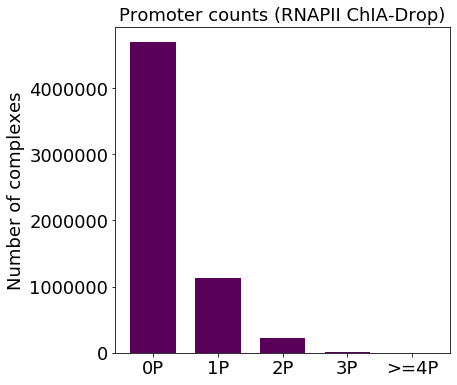

In [75]:
x1 = ['0P', '1P', '2P', '3P', '>=4P']
x2 = promcnt
plot_barchart(x1, x2, 'Number of complexes', "#590059",'Promoter counts (RNAPII ChIA-Drop)', '')

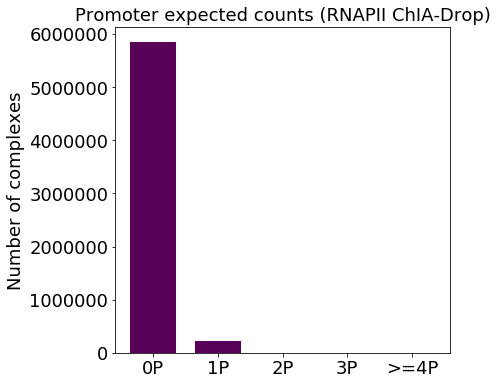

In [76]:
x1 = ['0P', '1P', '2P', '3P', '>=4P']
x2 = prom_exp
plot_barchart(x1, x2, 'Number of complexes', "#590059",'Promoter expected counts (RNAPII ChIA-Drop)', '')

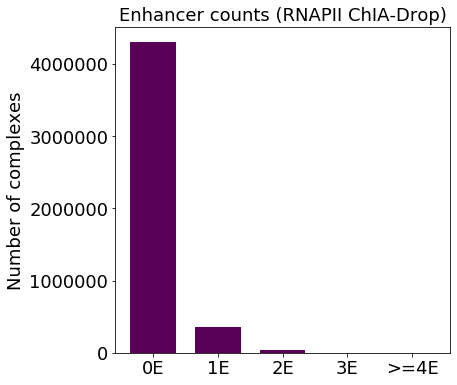

In [77]:
x1 = ['0E', '1E', '2E', '3E', '>=4E']
x2 = enhcnt
plot_barchart(x1, x2, 'Number of complexes', "#590059",'Enhancer counts (RNAPII ChIA-Drop)', '')

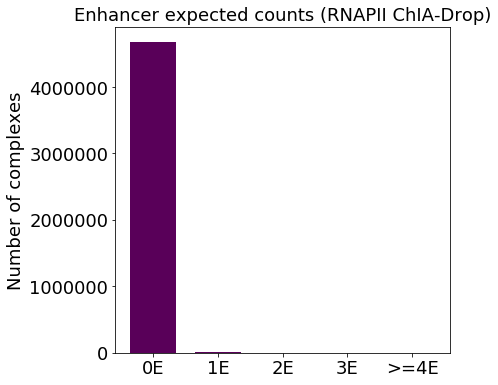

In [78]:
x1 = ['0E', '1E', '2E', '3E', '>=4E']
x2 = enh_exp
plot_barchart(x1, x2, 'Number of complexes', "#590059",'Enhancer expected counts (RNAPII ChIA-Drop)', '')

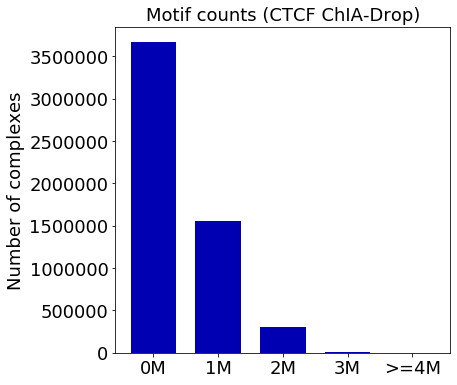

In [46]:
x1 = ['0M', '1M', '2M', '3M', '>=4M']
x2 = motcnt
plot_barchart(x1, x2, 'Number of complexes', "#0000B2",'Motif counts (CTCF ChIA-Drop)', '')

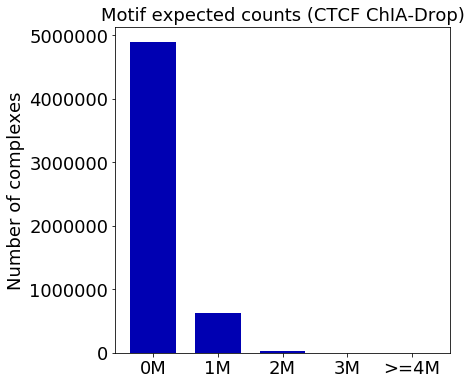

In [47]:
x1 = ['0M', '1M', '2M', '3M', '>=4M']
x2 = motif_exp
plot_barchart(x1, x2, 'Number of complexes', "#0000B2",'Motif expected counts (CTCF ChIA-Drop)', '')

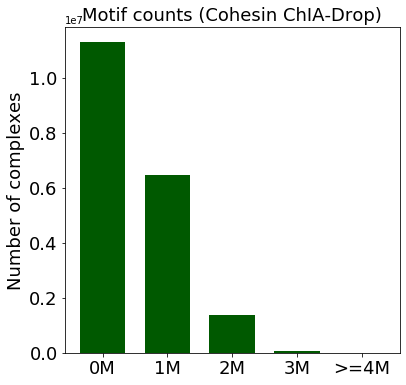

In [48]:
x1 = ['0M', '1M', '2M', '3M', '>=4M']
x2 = motcnt_coh
plot_barchart(x1, x2, 'Number of complexes', "#005900",'Motif counts (Cohesin ChIA-Drop)', '')

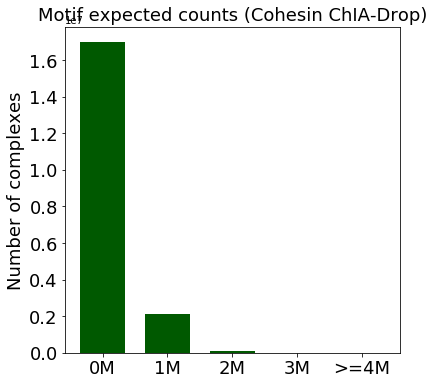

In [49]:
x1 = ['0M', '1M', '2M', '3M', '>=4M']
x2 = motif_exp_coh
plot_barchart(x1, x2, 'Number of complexes', "#005900",'Motif expected counts (Cohesin ChIA-Drop)', '')

In [79]:
def plot_ecdf(x1, x2, dlab, clr1, clr2, tit, xlab, fig_name):
    fig, ax = plt.subplots(figsize=(8, 7))
    
    n1, bins1, patches1 = ax.hist(x1, bins = 1000, normed=1, histtype='step', cumulative=True, label=dlab[0], color = clr1, linewidth = 4)
    n2, bins2, patches2 = ax.hist(x2, bins = 1000, normed=1, histtype='step', cumulative=True, label=dlab[1], color = clr2, linewidth = 4)
    patches1[0].set_xy(patches1[0].get_xy()[:-1])
    patches2[0].set_xy(patches2[0].get_xy()[:-1])
    ax.legend(loc = 'lower right', fontsize = 18)
    ksstat = stats.ks_2samp(x1, x2)
    tit = tit + "\n" + "Two-sided K-S test\n" + "stat = "+ str(round(ksstat[0], 4)) + "; pval = "+str(ksstat[1]) + "\n"
    tit = tit + dlab[0]+ ": " + ", ".join([str(x) for x in Counter(x1).values()]) + "\n"
    tit = tit + dlab[1]+ ": " + ", ".join([str(x) for x in Counter(x2).values()]) + "\n"
    tit = tit + "Total: " + str(len(x1)) + " complexes"
    plt.title(tit, fontsize = 18)
    plt.xlabel(xlab, fontsize = 18)
    plt.ylabel("Empirical Cum. Dist. Func. (ECDF)", fontsize = 18)
    plt.xticks(np.arange(5), ['0', '1', '2', '3', '>=4'], fontsize = 18) 
    plt.yticks(fontsize = 18)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()   

In [80]:
def cnts2raw(cntlist):
    tmplist = []
    for i in range(len(cntlist)):
        for j in range(cntlist[i]):
            tmplist.append(i)
    return tmplist

/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


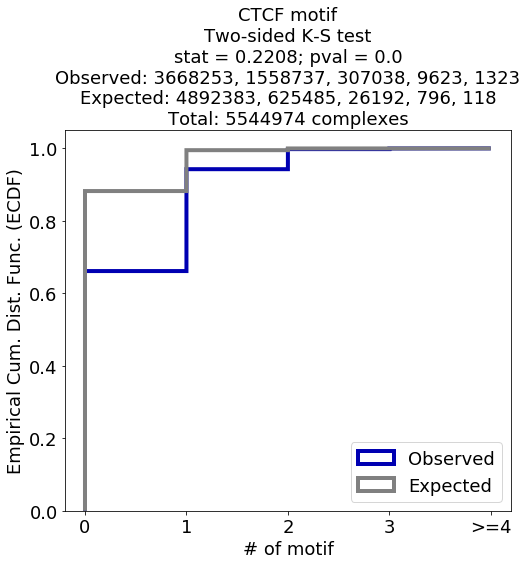

In [52]:
plot_ecdf(cnts2raw(motcnt), cnts2raw(motif_exp), ["Observed", "Expected"], "#0000B2", "gray", "CTCF motif", "# of motif", "CTCF-FDR0.1-ALL-motif-multiplexity_20200810")

/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


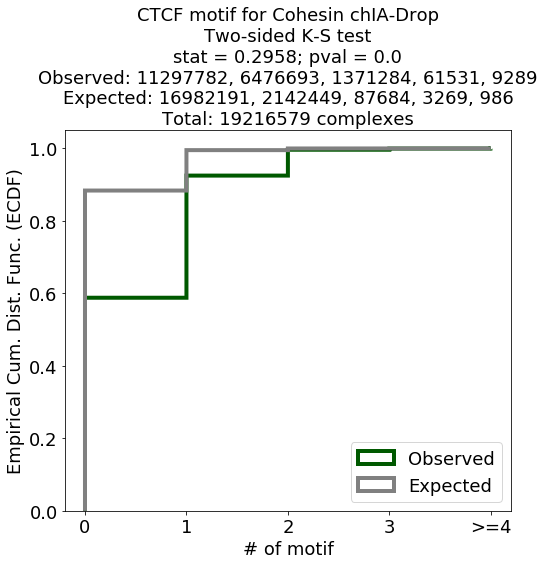

In [53]:
plot_ecdf(cnts2raw(motcnt_coh), cnts2raw(motif_exp_coh), ["Observed", "Expected"], "#005900", "gray", "CTCF motif for Cohesin chIA-Drop", "# of motif", "cohesin-FDR0.1-ALL-motif-multiplexity_20200804")

/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


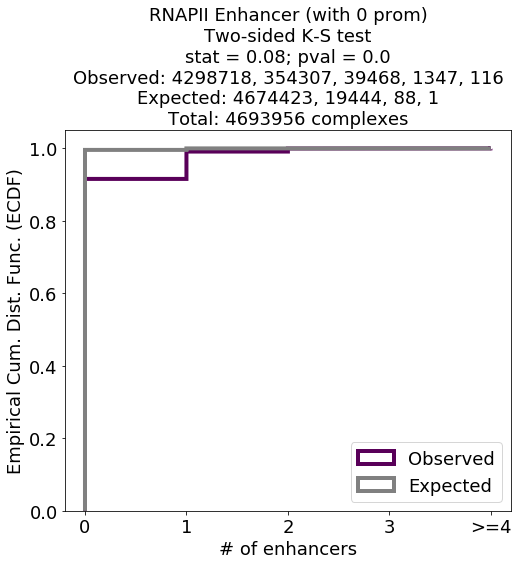

In [81]:
plot_ecdf(cnts2raw(enhcnt), cnts2raw(enh_exp), ["Observed", "Expected"], "#590059", "gray", "RNAPII Enhancer (with 0 prom)", "# of enhancers", "RNAPII-FDR0.1-ALL-enhancer-multiplexity_20200804")

/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/kimm/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


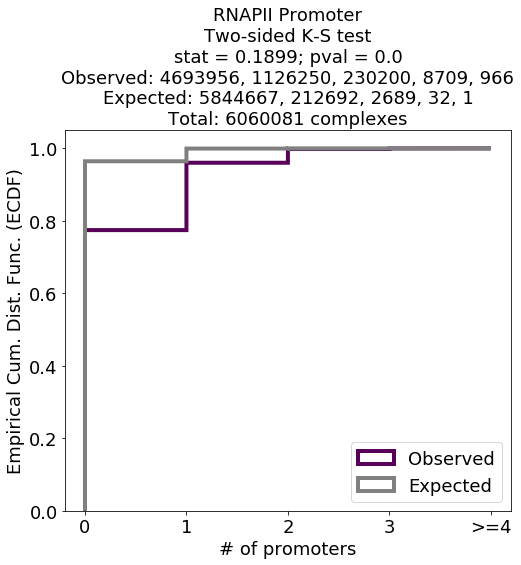

In [82]:
plot_ecdf(cnts2raw(promcnt), cnts2raw(prom_exp), ["Observed", "Expected"], "#590059", "gray", "RNAPII Promoter", "# of promoters", "RNAPII-FDR0.1-ALL-promoter-multiplexity_20200804")

In [83]:
promcnt

[4693956, 1126250, 230200, 8709, 966]

In [84]:
prom_exp

[5844667, 212692, 2689, 32, 1]

In [166]:
Counter(cnts2raw(prom_exp))

Counter({0: 2316500, 1: 82282, 2: 941, 3: 8, 4: 1})